# Nonnegative Matrix Factorization

Nonnegative matrix factorization (NMF) is an algorithm that factorizes a matrix, $X$, into a product of two matrices, $W$ and $H$. It is an unsupervised iterative algorithm that minimizes a distance between $X$ and the product $WH$:

$$ \min_{W, H} d(X, WH) $$

If $X$ has dimensions $M$ by $N$, then $W$ will have dimensions $M$ by $R$, and $H$ will have dimensions $R$ by $N$, where inner dimension $R$ is the *rank* or *number of components* of the decomposition.

When applied to a musical signal, we find that NMF can decompose the signal into separate note events. Therefore, NMF is quite useful and popular for tasks such as transcription and source separation.

The input, $X$, is often a magnitude spectrogram. In such a case, we find that the columns of $W$ represent spectra of note events, and the rows of $H$ represent temporal envelopes of the same note events.

In [22]:
from sklearn.decomposition import NMF
from IPython.display import Audio
import soundfile as sf
import librosa
import numpy as np
import librosa.display as ld
import matplotlib.pyplot as plt

Let's load a signal:

In [23]:
x, fs = sf.read('Test_1.wav')
print(x.shape)

# Mezclando ambos canales
audio_mono = 0.5 * (x[:,0] + x[:,1])

Audio(audio_mono, rate=fs)

(1165528, 2)


In [24]:
# Lectura del audio
audio, samplerate = sf.read('Drums.wav')

print(audio.shape)

# Normalizar audio
audio_mono = audio/max(abs(audio))

# Escuchar
Audio(audio_mono, rate=samplerate)

(132300,)


Compute the spectrogram:

In [30]:
S = librosa.stft(audio_mono)
print(S.shape)
X = np.abs(S)

(1025, 259)


In [5]:
1025*2277

2333925

Display the spectrogram:

<IPython.core.display.Javascript object>


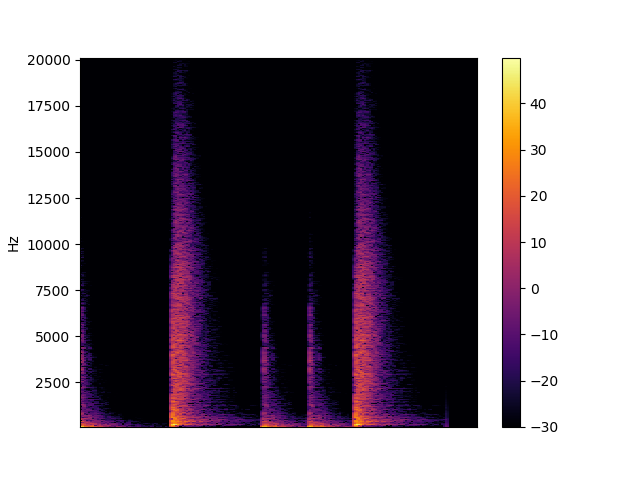

In [21]:
%matplotlib notebook
logX = librosa.amplitude_to_db(X)
ld.specshow(logX, sr=fs, y_axis='linear', cmap='inferno')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


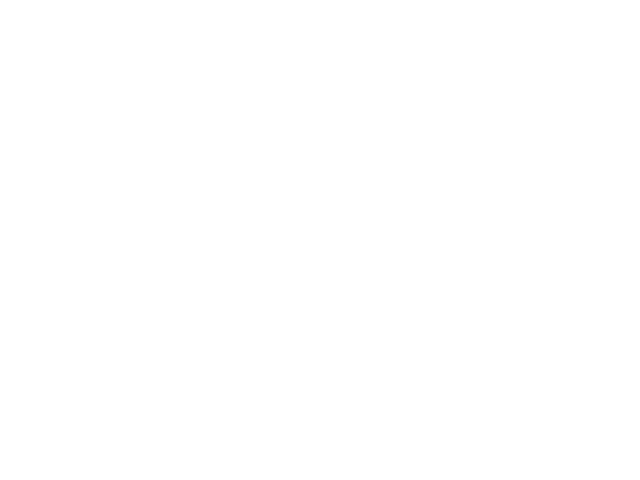

In [6]:
%matplotlib notebook
plt.pcolormesh(range(X.shape[1]), range(X.shape[0]), 20*np.log10(X), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

<IPython.core.display.Javascript object>


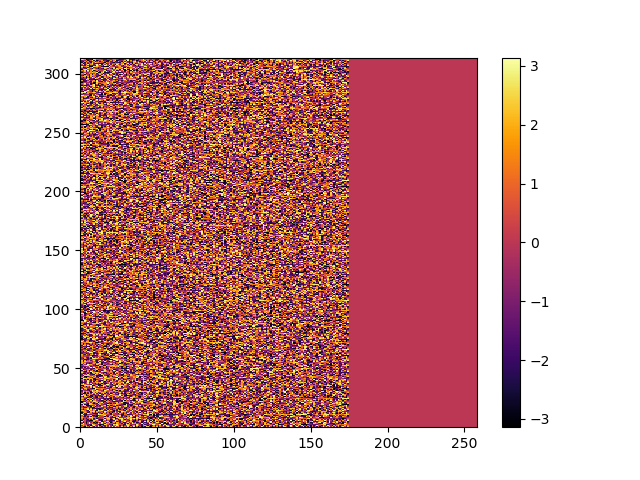

In [7]:
%matplotlib notebook
angle_S = np.angle(S)
t = range(X.shape[1])
f = np.linspace(np.min(X), np.max(X), X.shape[0])
plt.pcolormesh(t, f, np.angle(S), cmap='inferno')
plt.colorbar()
plt.show()

In [24]:
print(S)
print(angle_S)

[[-3.7715691e+01+0.0000000e+00j -1.0947308e+01+0.0000000e+00j
  -2.4174334e+01+0.0000000e+00j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 1.0639902e+01-5.9154071e-15j  1.1991259e+01+3.2793884e+01j
   2.5146547e+01-4.9893585e+01j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 1.9524980e+02-1.8969034e-15j -6.2938015e+01-2.0017067e+02j
  -9.3053741e+01+1.6489015e+02j ...  0.0000000e+00-0.0000000e+00j
   0.0000000e+00-0.0000000e+00j  0.0000000e+00-0.0000000e+00j]
 ...
 [-2.3539164e-03+1.2307696e-15j  1.7789234e-03+5.3076952e-04j
  -7.2999415e-04-9.4506628e-04j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 1.8001349e-03+1.1345092e-15j -1.0599645e-03-8.7273261e-04j
   4.8702810e-04+1.1182682e-03j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [-8.4240513e-04+0.0000000e+00j -1.89330

In [8]:
a = np.array([[1,2,3],[10, 5, 6]])
np.max(a)

10

## `sklearn.decomposition.NMF`

We use `sklearn.decomposition.NMF` in a manner similar to `KMeans` and `KNearestNeighbor`. 

First, the `fit` method trains a model. 

In [9]:
model = NMF(n_components=2)#, beta_loss = 'itakura-saito', solver='mu')
model.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=2, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

To extract the matrix $W$, use `transform`:

In [10]:
W = model.transform(X)
print(W.shape)

(1025, 2)


Let's display the two spectra:

<IPython.core.display.Javascript object>


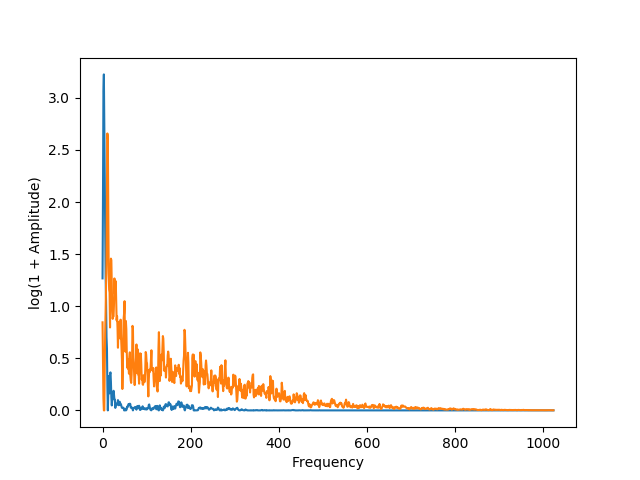

In [11]:
%matplotlib notebook
logW = np.log1p(W)
f = np.arange(W.shape[0])
plt.plot(f, logW[:,0], f, logW[:,1])
plt.xlabel('Frequency')
plt.ylabel('log(1 + Amplitude)')
plt.show()

Let's display the temporal activations:

(2, 259)


<IPython.core.display.Javascript object>


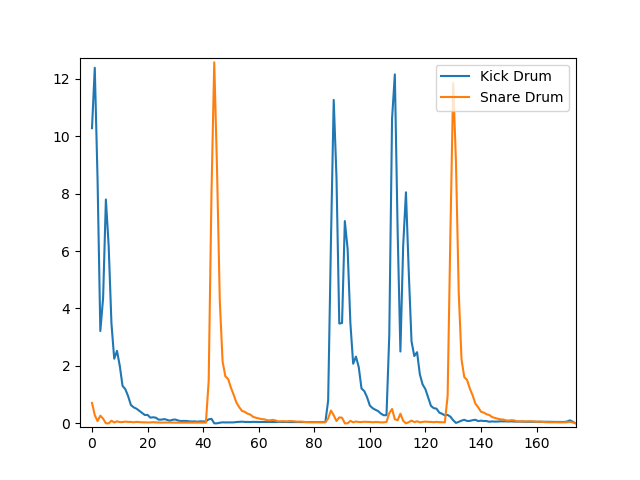

In [16]:
%matplotlib notebook
H = model.components_
print(H.shape)
t = np.arange(H.shape[1])
plt.plot(t, H[0], t, H[1])
plt.legend(('Kick Drum', 'Snare Drum'))
plt.show()

In [19]:
Y0 = np.outer(W[:,0], H[0])*np.exp(1j*np.angle(S))
Y1 = np.outer(W[:,1], H[1])*np.exp(1j*np.angle(S))
y0 = librosa.istft(Y0)
y1 = librosa.istft(Y1)
y0.shape, y1.shape

((132096,), (132096,))

<IPython.core.display.Javascript object>


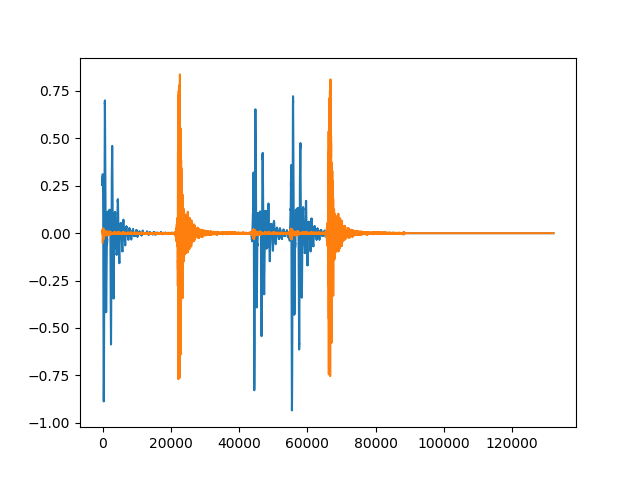

In [20]:
%matplotlib notebook
t = np.arange(len(y0))
plt.plot(t, y0, t, y1)
plt.show()

In [21]:
Audio(y0, rate=fs)

In [28]:
Audio(y1, rate=fs)

In [29]:
Audio((y0 + y1)/2, rate=fs)